In [1]:
import torch

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from shap_e.util.image_util import load_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# xm is for rendering latents
xm = load_model('transmitter', device=device)
# model = load_model('image300M', device=device)
# diffusion = diffusion_from_config(load_config('diffusion'))

In [4]:
create_latent = False
batch_size = 4
guidance_scale = 3.0

# To get the best result, you should remove the background and show only the object of interest to the model.
# image = load_image("example_data/corgi.png")
# image = load_image("example_data/cube.png")
image = load_image("../../../content/cube_tall.png")

if create_latent:
    latents = sample_latents(
        batch_size=batch_size,
        model=model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(images=[image] * batch_size),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )

In [5]:

# load latents from file
latents_cube = torch.load('../../latents/cube_latents.pt')
latents_cube_tall = torch.load('../../latents/cube_tall_latents.pt')

In [6]:
# print minimum and maximum values of latents
print(f'latents_cube min: {latents_cube.min()}')
print(f'latents_cube max: {latents_cube.max()}')
print(f'latents_cube_tall min: {latents_cube_tall.min()}')
print(f'latents_cube_tall max: {latents_cube_tall.max()}')

latents_cube min: -1.1279296875
latents_cube max: 1.1064453125
latents_cube_tall min: -1.12890625
latents_cube_tall max: 1.1171875


In [7]:
# function for plotting a histogram of latents
def plot_hist(latents):
    import matplotlib.pyplot as plt
    plt.hist(latents.flatten().cpu().numpy(), bins=500)
    plt.show()

In [8]:
# function for interpolating among two latent vectors
def interpolate_latents(lat_A, lat_B, intp_steps):
    latents = []
    for i in range(intp_steps):
        latents.append(lat_A + (lat_B - lat_A) * i / intp_steps)
    return latents


In [9]:
# function for extrapolating from a latent vector
def extrapolate_latents(lat_A, lat_B, extp_steps):
    latents = []
    for i in range(extp_steps):
        latents.append(lat_B + (lat_B - lat_A) * i / extp_steps)
    return latents

In [10]:
# function for extracting transformation from two latent vectors
def extract_transformation(lat_A, lat_B):
    return lat_B - lat_A

In [11]:
latent_transform = extract_transformation(latents_cube[0], latents_cube_tall[0])
# print the indices of five largest values in the latent_transform vector
print(torch.topk(latent_transform, 5))

torch.return_types.topk(
values=tensor([2.0791, 2.0684, 2.0576, 2.0566, 2.0527], device='cuda:0'),
indices=tensor([788474, 979962, 860154, 972375, 653013], device='cuda:0'))


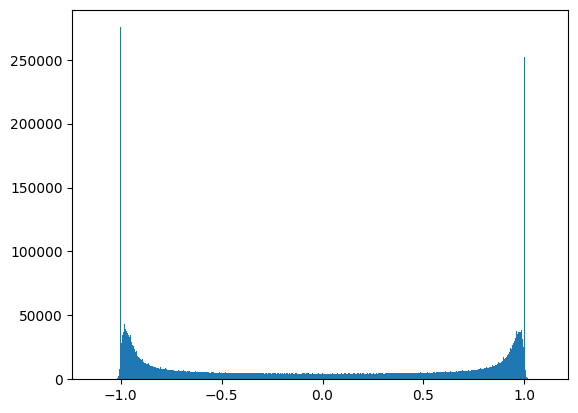

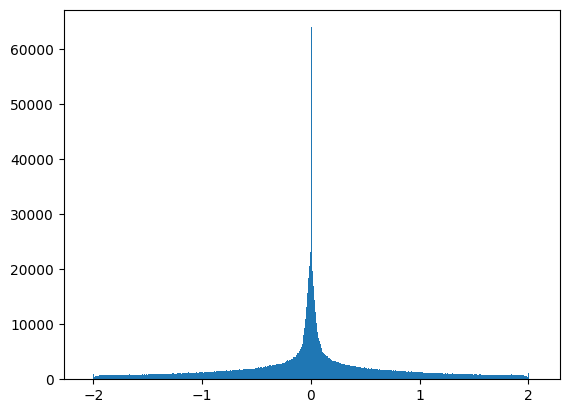

In [12]:
plot_hist(latents_cube)
plot_hist(latent_transform)

In [13]:
# function for rendering interpolated or extrapolated latents
def render_latents(latents, name):
    for i, latent in enumerate(latents):
        images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
        # display(gif_widget(images))
        # save image to disk
        images[0].save('../../../content/{}_{}.gif'.format(name, i), save_all=True, append_images=images[1:], duration=100, loop=0)

In [14]:
# function for rendering the interpolation between two latents as a single gif
def render_transformation(latents, name):
    # render the first frame from the first latent, second frame from the second latent, and so on
    images = []
    for i, latent in enumerate(latents):
        images.append(decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)[0])
        
    # write images to a gif
    images[0].save('../../../content/{}.gif'.format(name), save_all=True, append_images=images[1:], duration=100, loop=0)

In [15]:
# interpolate between two latents
intp_latents = interpolate_latents(latents_cube[3], latents_cube_tall[0], 20)
extp_latents = extrapolate_latents(latents_cube_tall[0], latents_cube[0], 10)

> *render_transformation* function below took:

| size | samples | time |
| --- | --- | --- |
| 32 | 5 | 15m21.0s |
| 32 | 10 | 38m25.5s |
| 32 | 10 | 54m50.5s |
|___|___|___|
| 64 | 20 | 14m5.7s |
| 64 | 20 | 19m40.4s |
| 32 | 20 | 3m31.8s |
| 32 | 20 | 3m32.3s |
| 64 | 20 | 31m.52.9s |

In [21]:
render_mode = 'nerf' # you can change this to 'stf' for mesh rendering
# size = 64 # this is the size of the renders; higher values take longer to render.
size = 64 # this is the size of the renders; higher values take longer to render.
cameras = create_pan_cameras(size, device)
render = True
if render:
    render_transformation(intp_latents[0:20], 'transformation_render_test_20_64_3')

*size* is not functional at the moment. I need to re-check the rendering function

In [22]:
size = 128
render = False
if render:
    cameras = create_pan_cameras(size, device)
    render_latents(intp_latents[0:20], 'render_test')

In [23]:
render = False
if render:
    render_latents(extp_latents, size, 'cube_intp')

In [24]:
# save latents to file
save_latents = False
if save_latents:
    torch.save(latents, '../../latents/cube_tall_latents.pt')